In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

# Introduction

This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know. 

We develop our models using TensorFlow and TensorFlow Probability (TFP). TFP is a Python library built on top of TensorFlow. We are going to start with the basic objects that we can find in TensorFlow Probability (TFP) and understand how can we manipulate them. We will increase complexity incrementally over the following weeks and combine our probabilistic models with deep learning on modern hardware (e.g. GPU).



As usual, the code is available on my GitHub.

# Maximum Likelihood Estimation

Let's recall what we shared at the end of the last article regarding Maximum Likelihood Estimation (MLE).

MLE is the usual training procedure used in deep learning models. The goal is to estimate the parameters of a probability distribution, given some data. In very simple terms, we want to maximize the probability of the data that we observed under some assumed statistical model, i.e. probability distribution.

We also introduced some notation. The probability density function of a continuous random variable roughly indicates the probability of a sample taking a particular value. We will denote this function $P(x | \theta)$ where $x$ is the value of the sample and $\theta$ is the parameter describing the probability distribution:

$$
P(x | \theta) = \text{Prob} (\text{sampling value $x$ from a distribution with parameter $\theta$}).
$$

In [5]:
tfd.Normal(0, 1).prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3989423>

It may seem fancy, but in fact, we have been computing the PDF of Gaussian distributions for a while now, so nothing particularly new here.

When more than one sample is drawn *independently* from the same distribution (which we usually assume), the probability density function of the sample values $x_1, \ldots, x_n$ is the product of the probability density functions for each individual $x_i$. Written formally:

$$
P(x_1, \ldots, x_n | \theta) = \prod_{i=1}^n P(x_i | \theta).
$$

We can easily compute the above with an example. Imagine that we have a standard Gaussian distribution and some samples: $x_1=-0.5$, $x_2=0$ and $x_3=1.5$. As we defined above, we just need to compute the PDF of each sample and multiply the output together.

In [6]:
X = [-0.5, 0, 1.5]

np.prod(tfd.Normal(0, 1).prob(X))

0.01819123

Now, I want to somehow give some intuition about the differences between a probability density function a likelihood function. They are essentially computing similar things, but with opposite perspectives.

Starting with the probability density function, we know that they are functions of our samples $x_1, \ldots, x_n$. Notice that the parameter $\theta$ is considered fixed. So, the probability density function is used when the parameter $\theta$ is known and our interest is to find out the probabilities of same samples $x_1, \ldots, x_n$. In simple terms, we use this function when we know the distribution that generated some process and we want to make deductions about possible values sampled from it.

Conversely, in the case of the *likelihood* function, what is known to us are the samples, i.e. the observed data $x_1, \ldots, x_n$. This means that our independent variable is now $\theta$, since we do not know which distribution generated this process that we observed. Hence, we use this function when the samples of some process are known to us, i.e. we collected data, but we do not really what distribution generated the process in the first place. Since we know the data, we are interested to make *inferences* about the distribution that they came from.

Let's introduce some more notation to help connect the dots. For the *likelihood* function, the convention is to use the letter $L$, while for the probability density function we introduced the notation above. We can then write the following:

$$
\underbrace{L(x_1, \ldots, x_n | \theta)}_{\text{ likelihood,} \\ \text{function of $\theta$}} = \underbrace{P(x_1, \ldots, x_n | \theta)}_{\text{probabiliy density,} \\ \text{ function of $x_1, \ldots, x_n$}}
$$

We are ready to define our likelihood function for the Gaussian distribution with parameters $\mu$ and $\sigma$:

$$\begin{aligned}
L = f(X|\theta) &= f(x_1|\theta) f(x_2|\theta),..., f(x_n|\theta) \\
&= \prod^n_{j=1}f(X| \mu,\sigma^2) \\
&= (2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(x_i-\mu)^2\big)}
\end{aligned}$$

As an exercise to get some more intuition about the *likelihood* function, we can generate enough samples to get a visual glimpse of its shape. Notice the difference of computing the *likelihood* function when compared to the computation of the probability density function that we did in the last article. We are not interested in generating samples from a probability distribution, we are interested in generating parameters $\theta$ that maximize the probability of the observed data, i.e. $P(x_1, \ldots, x_n | \theta) = \prod_{i=1}^n P(x_i | \theta)$.

We are using the same samples as above $x_1=-0.5$, $x_2=0$ and $x_3=1.5$.

In [9]:
X

[-0.5, 0, 1.5]

To be able to build a 2D visualization, we can create a grid of potential parameters sampled evenly spaced over an interval, $\mu$ is sampled from [-2,2] and $\sigma$ between [0,3]. Since we sampled 100 values for each parameter we got $n^2$ possible combinations. For each combination of parameters, we need to compute the probability of each sample and multiply them together (following the procedure that we shared above).

In [11]:
μ = np.linspace(-2, 2, 100)
σ = np.linspace(0, 3, 100)

l_x = []
for mu in μ:
    for sigma in σ:
        l_x.append(np.prod(tfd.Normal(mu, sigma).prob(X)))
        
l_x = np.asarray(l_x).reshape((100, 100)).T

We are now ready to plot the *likelihood* function. Note that it is function of the observed samples and Recall that these are fixed, the parameters are our independent variables.

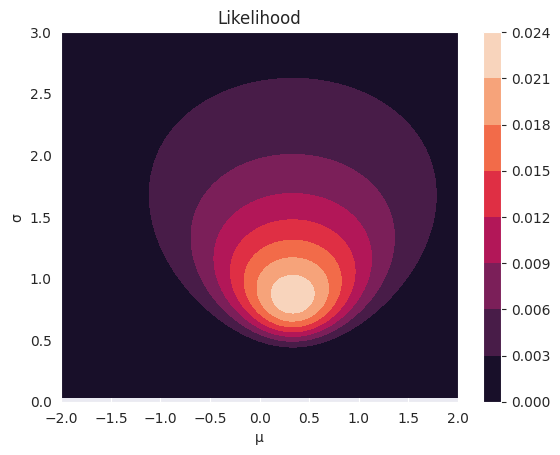

In [8]:
plt.contourf(μ, σ, l_x)
plt.xlabel('μ')
plt.ylabel('σ')
plt.colorbar()
plt.title('Likelihood');

As we already shared, we are interested in maximizing the probability of our data. This means that we want to find the maximum value of the *likelihood* function, which can be achieved with a bit of calculus. In fact, the zeros of the first derivative of our function with respect to our parameters should be sufficient to help us find the maximum of the original function. We now get to a new problem that we already introduced in a previous article - multiplying many small probabilities together can be numerically unstable.  To overcome this problem, we can use the log transformation of the same function. The natural logarithm is a monotonically increasing function, which means that if the value on the x-axis increases, the value on the y-axis also increases. This is important because it ensures that the maximum value of the log of the probability occurs at the same point as the original probability function. It does another very conveniently thing for us, it transforms our products into sums.

Let's perform the transformation:

$$\begin{aligned}
\log(L(X|\theta)) &= \log\big((2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(y_i-\mu)^2\big)\big)} \\
&= -\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(y_i-\mu)^2
\end{aligned}$$

We are almost there, we can now work our optimization problem at hand. Maximizing the probability of our data can be written as:

$$\max_{\mu,\sigma^2}\log(L(X|\theta))$$

As we stated above, the expression derived above can be differentiated to find the maximum. Expanding our parameters we have $\log(L(X|\mu, \sigma))$. As it is a function of the two variables $\mu$ and $\sigma$ we use partial derivatives to find the *Maximum Likelihood Estimation*. 

Let's focus on $\hat \mu$ (the hat indicates that it is an estimator, i.e. our output), we compute it from

$$\begin{aligned}
& \quad \frac{\partial}{\partial \mu} \log(L(Y|\mu, \sigma)) \\
&= \frac{\partial}{\partial \mu} \big(-\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(x_i-\mu)^2\big)
\\
&= \sum^n_{j=1} \frac{(x_i - \mu)}{\sigma^2}
\end{aligned}$$

Setting the expression above equal to zero we get


$$\sum^n_{j=1} \frac{(x_i - \mu)}{\sigma^2} = 0 $$

Then
$$\begin{aligned}
\hat\mu &= \frac{\sum^n_{j=1}x_i}{n} \\
\hat\mu &= \bar x
\end{aligned}$$

It should not be a surprise to you that this is the mean of the data.

We can compute the maximum values for the μ and σ for our samples $x_1=-0.5$, $x_2=0$ and $x_3=1.5$ and compare with the true values.

In [17]:
idx_μ_max = np.argmax(l_x, axis=1)[-1]
print(f'μ True Value: {np.array(X).mean()}')
print(f'μ Calculated Value: {μ[idx_μ_max]}')
print(f'σ True Value: {np.array(X).std()}')
print(f'σ Calculated Value: {σ[np.nanargmax(l_x[:,idx_μ_max], axis=0)]}')

μ True Value: 0.3333333333333333
μ Calculated Value: 0.3434343434343434
σ True Value: 0.8498365855987975
σ Calculated Value: 0.8484848484848485


# Maximum Likelihood Estimation implementation in TensorFlow Probability

Let's start by creating a random variable normally distributed and sample from it.

In [37]:
x_train = np.random.normal(loc=1, scale=5, size=1000).astype('float32')[:, np.newaxis]

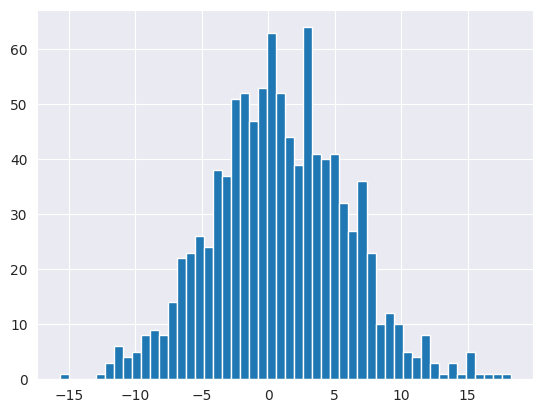

In [38]:
# Plot a histogram of the random variable

plt.hist(x_train, bins=50);

In [43]:
# Calculate the mean of the samples of the random variable

x_train.mean()

0.85486585

As we saw in the last article, we can define TensorFlow `Variable` objects as the parameters of our distribution. This signals to TensorFlow that we want to learn these parameters during the learning procedure, whichever we use.

In [27]:
normal = tfd.Normal(loc=tf.Variable(0., name='loc'), scale=5)
normal.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.0>,)

The next step if to define our loss function. In this case, we already saw what we want to achieve - maximize our log transformation of the *likelihood* function. However, in Deep Learning we usually minimize our loss functions, which can be easily achieved if we change the sign of our *likelihood* function to be negative.

In [28]:
# Define the negative log likelihood function (loss function)

def nll(x_train):
    return -tf.reduce_sum(normal.log_prob(x_train))

Finally, we can build our training procedure. We will use a custom training loop, so that we can define the procedure details ourselves (namely use our custom loss function).

As we also shared in a previous article, we use `tf.GradientTape()` which is the API to access the automatic differentiation features of TensorFlow. Next, we simply specify what are the variables to train, the loss function to minimize and apply the gradients.

In [40]:
# Custom training loop

@tf.function
def get_loss_and_grads(x_train):
    with tf.GradientTape() as tape:
        tape.watch(normal.trainable_variables)
        loss = nll(x_train)
        grads = tape.gradient(loss, normal.trainable_variables)
    return loss, grads

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)


We are ready to run our training procedure for some epochs.

In [42]:
for i in range(2000):
    loss, grads = get_loss_and_grads(x_train)
    optimizer.apply_gradients(zip(grads, normal.trainable_variables))
    
    loc_value = normal.loc.value()
    print("Step {:03d}: Loss: {:.3f} Loc: {:.3f}".format(i, loss, loc_value))

Step 000: Loss: 13768.004 Loc: 0.855
Step 001: Loss: 13768.004 Loc: 0.855
Step 002: Loss: 13768.004 Loc: 0.855
Step 003: Loss: 13768.004 Loc: 0.855
Step 004: Loss: 13768.004 Loc: 0.855
Step 005: Loss: 13768.004 Loc: 0.855
Step 006: Loss: 13768.004 Loc: 0.855
Step 007: Loss: 13768.004 Loc: 0.855
Step 008: Loss: 13768.004 Loc: 0.855
Step 009: Loss: 13768.004 Loc: 0.855
Step 010: Loss: 13768.004 Loc: 0.855
Step 011: Loss: 13768.004 Loc: 0.855
Step 012: Loss: 13768.004 Loc: 0.855
Step 013: Loss: 13768.004 Loc: 0.855
Step 014: Loss: 13768.004 Loc: 0.855
Step 015: Loss: 13768.004 Loc: 0.855
Step 016: Loss: 13768.004 Loc: 0.855
Step 017: Loss: 13768.004 Loc: 0.855
Step 018: Loss: 13768.004 Loc: 0.855
Step 019: Loss: 13768.004 Loc: 0.855
Step 020: Loss: 13768.004 Loc: 0.855
Step 021: Loss: 13768.004 Loc: 0.855
Step 022: Loss: 13768.004 Loc: 0.855
Step 023: Loss: 13768.004 Loc: 0.855
Step 024: Loss: 13768.004 Loc: 0.855
Step 025: Loss: 13768.004 Loc: 0.855
Step 026: Loss: 13768.004 Loc: 0.855
S

In [44]:
# Compare the true value and the estimated parameter

print(f'True Value: {x_train.mean()}')
print(f'Estimated Value: {normal.trainable_variables[0].numpy()}')

True Value: 0.8548658490180969
Estimated Value: 0.8548658490180969


# Conclusion

This article introduced the  Maximum Likelihood Estimation procedure both theoretically as well as in practice by computing an example in TensorFlow Probability. We started by stating the differences between the probability density function and the likelihood function. The first has the parameter 𝜃 fixed and the samples are the variables of interest. Conversely, in the case of the likelihood function,  it is the other way around, the data is fixed (i.e. observed) and the parameter 𝜃 is the variable that we want to learn. We then implemented a very simple example that allowed us to get a visual intuition of the shape of the likelihood function. Finally, we implemented a custom training procedure using TensorFlow Probability by defining a TensorFlow Variable, a negative log likelihood function and by applying the gradients.

Next week, we will start building our first algorithms. See you then!


# References and Materials

[1] - [Coursera: TensorFlow 2 for Deep Learning Specialization](https://www.coursera.org/specializations/tensorflow2-deeplearning)

[2] - [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

[3] - [TensorFlow Probability Guides and Tutorials](https://www.tensorflow.org/probability/overview)

[4] - [TensorFlow Probability Posts in TensorFlow Blog](https://blog.tensorflow.org/search?label=TensorFlow+Probability&max-results=20)